# Задача

Разработать нейросеть для определения температуруы на поверхности обнаруженных звёзд. В базе содержатся характеристики уже изученных 240 звёзд.

## Характеристики

* `Относительная светимость L/Lo` — светимость звезды относительно Солнца.
* `Относительный радиус R/Ro` — радиус звезды относительно радиуса Солнца.
* `Абсолютная звёздная величина Mv` — физическая величина, характеризующая блеск звезды.
* `Звёздный цвет (white, red, blue, yellow, yellow-orange и др.)` — цвет звезды, который определяют на основе спектрального анализа.
* `Тип звезды`
* `Абсолютная температура T(K)` — температура на поверхности звезды в Кельвинах.

# Загрузка и подготовка исходных данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
from math import sqrt
from sklearn.metrics import mean_squared_error
from math import ceil

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

In [2]:
def data_info(file_path):
    df = pd.read_csv(file_path, index_col=0)
    display(df.head(5))
    display(df.info())
    display(df.describe())
    print('Количество дубликатов:', df.duplicated().sum())
    print('Общее количество пропусков:', df.isnull().sum().sum())
    return df

In [3]:
df = data_info('/Users/sancho/Desktop/Прогнозирование температуры звезды/6_class.csv')

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
Unnamed: 0,,,,,,
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


None

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


Количество дубликатов: 0
Общее количество пропусков: 0


In [4]:
df.columns

Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

Для удобства переименуем названия колонок:

In [5]:
df = df.rename(columns={'Temperature (K)': 'temperature', 'Luminosity(L/Lo)': 'luminosity', 
                        'Radius(R/Ro)': 'radius', 'Absolute magnitude(Mv)': 'absolute_magnitude', 
                        'Star type': 'star_type', 'Star color': 'star_color'})

In [6]:
df.columns

Index(['temperature', 'luminosity', 'radius', 'absolute_magnitude',
       'star_type', 'star_color'],
      dtype='object')

Проверим столбец с категориальным признаком на предмет неявных дубликатов:

In [7]:
df['star_color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Столбец содержит неявные дубликаты, по-разному записаны одни и те же цвета.

In [8]:
df['star_color'] = df['star_color'].replace(['Blue-white', 'Blue White', 'Blue white', 'Blue white '], 'Blue-White')
df['star_color'] = df['star_color'].replace(['yellow-white', 'Yellowish White', 'White-Yellow'], 'Yellow-White')
df['star_color'] = df['star_color'].replace(['white', 'Whitish'], 'White')
df['star_color'] = df['star_color'].replace(['yellowish', 'Yellowish'], 'Yellow')
df['star_color'] = df['star_color'].replace(['Pale yellow orange'], 'Yellow-Orange')
df['star_color'] = df['star_color'].replace(['Blue '], 'Blue')

In [9]:
df['star_color'].value_counts().to_frame()

,star_color
Red,112
Blue,56
Blue-White,41
White,12
Yellow-White,12
Yellow,3
Orange,2
Yellow-Orange,1
Orange-Red,1


Проверим столбец с типом звезды:

In [10]:
df['star_type'].value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: star_type, dtype: int64

**В результате предобработки переименованы колонки, обработаны неявные дубликаты в столбце `star_color`.**

# Исследовательский анализ

**Абсолютная температура**

array([[<AxesSubplot:title={'center':'temperature'}>]], dtype=object)

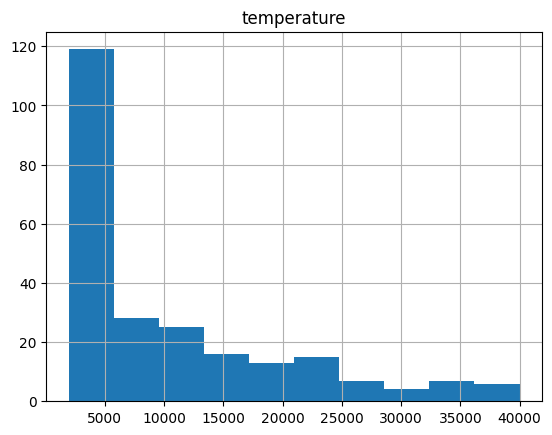

In [11]:
df.hist('temperature')

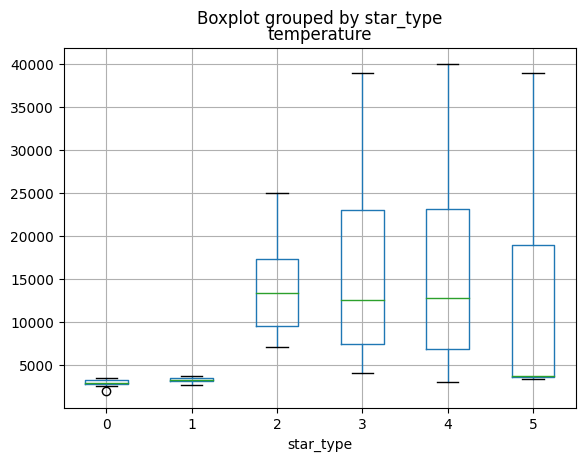

In [12]:
df['boxplot_temp'] = df.boxplot(column = 'temperature', by = 'star_type')

In [13]:
#Q1 = df['boxplot_temp'].quantile(0.25)
#Q3 = df['boxplot_temp'].quantile(0.75)
#IQR = Q3 - Q1    #IQR is interquartile range. 

#df_IQR = df[(df['boxplot_temp'] > Q1) & (df['boxplot_temp'] < Q3)]
#df_IQR.boxplot(column="boxplot_temp")

In [14]:
#df = df.query('temperature > 2000')

**Относительная светимость**

array([[<AxesSubplot:title={'center':'luminosity'}>]], dtype=object)

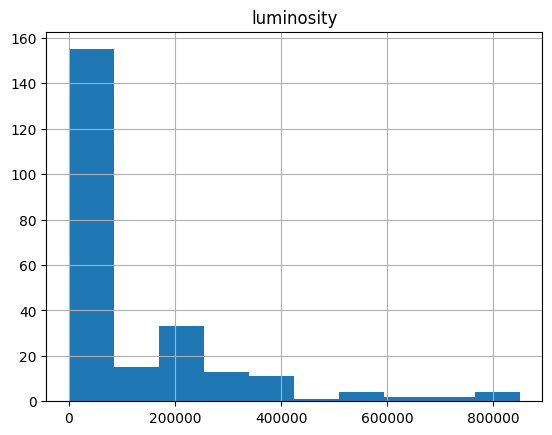

In [15]:
df.hist('luminosity')

<AxesSubplot:title={'center':'luminosity'}, xlabel='star_type'>

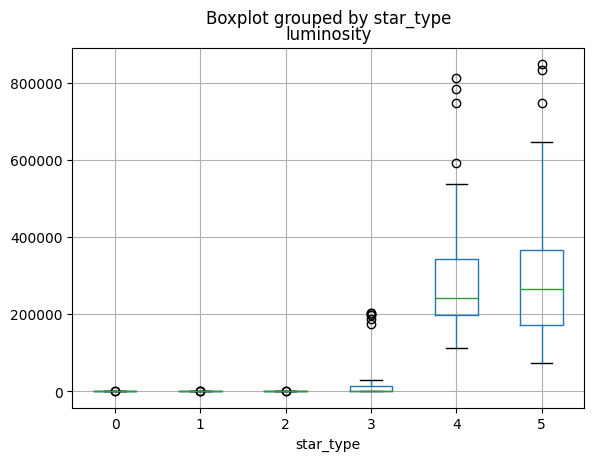

In [16]:
df.boxplot(column = 'luminosity', by = 'star_type')

In [17]:
#df = df.query('luminosity < 550000')

In [18]:
#df.boxplot(column = 'luminosity', by = 'star_type')

**Относительный радиус**

array([[<AxesSubplot:title={'center':'radius'}>]], dtype=object)

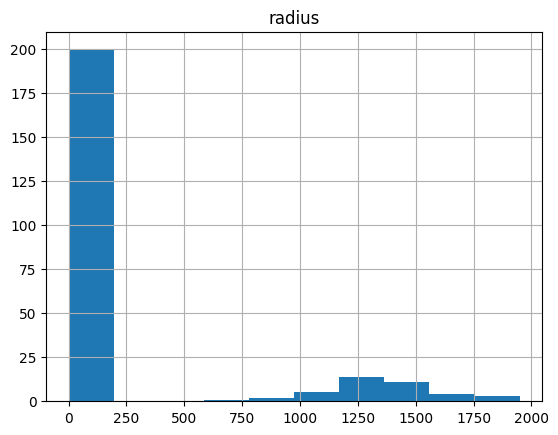

In [19]:
df.hist('radius')

<AxesSubplot:title={'center':'radius'}, xlabel='star_type'>

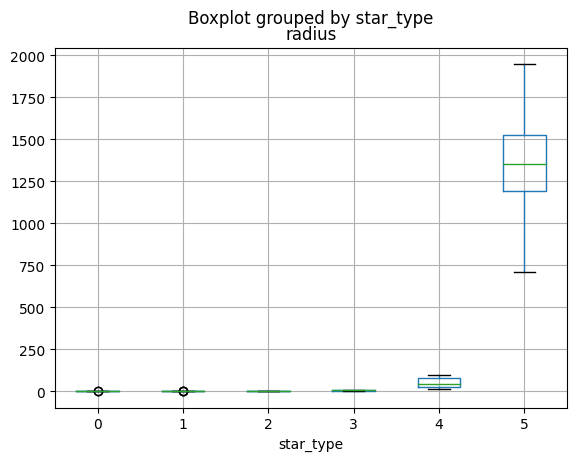

In [20]:
df.boxplot(column = 'radius', by = 'star_type')
# plt.ylim(0, 2000)

In [21]:
# df = df.query('radius <= 600')

**Абсолютная звёздная величина**

array([[<AxesSubplot:title={'center':'absolute_magnitude'}>]],
      dtype=object)

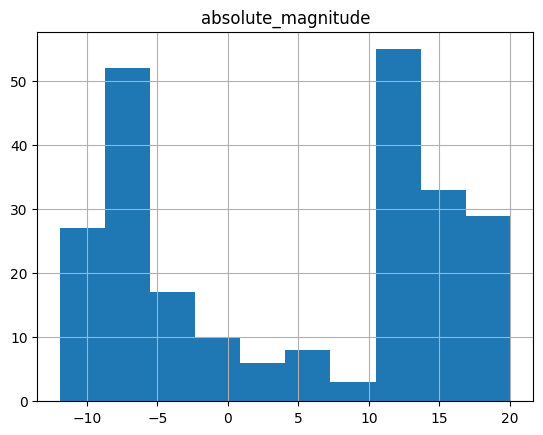

In [22]:
df.hist('absolute_magnitude')

<AxesSubplot:title={'center':'absolute_magnitude'}, xlabel='star_type'>

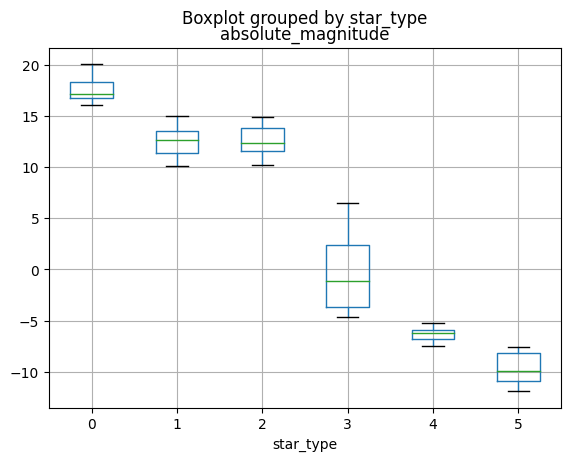

In [23]:
df.boxplot(column = 'absolute_magnitude', by = 'star_type')

In [24]:
def fun(x):
    q_99 = x.quantile(0.99)
    q_1 = x.quantile(0.01)
    return (x>q_99) | (x<q_1)

df["is_outlier"] = df.groupby("luminosity")["star_type"].transform(lambda x: fun(x)) 

<AxesSubplot:title={'center':'luminosity'}, xlabel='star_type'>

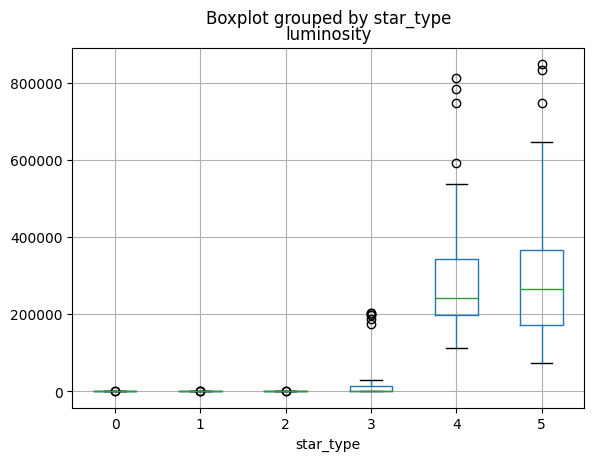

In [25]:
df.boxplot(column = 'luminosity', by = 'star_type')

# Подготовка данных к построению модели

Преобразуем категориальный признак в численный с помощью техники OHE.

In [26]:
df = pd.get_dummies(df, drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   temperature               240 non-null    int64  
 1   luminosity                240 non-null    float64
 2   radius                    240 non-null    float64
 3   absolute_magnitude        240 non-null    float64
 4   star_type                 240 non-null    int64  
 5   is_outlier                240 non-null    bool   
 6   star_color_Blue-White     240 non-null    uint8  
 7   star_color_Orange         240 non-null    uint8  
 8   star_color_Orange-Red     240 non-null    uint8  
 9   star_color_Red            240 non-null    uint8  
 10  star_color_White          240 non-null    uint8  
 11  star_color_Yellow         240 non-null    uint8  
 12  star_color_Yellow-Orange  240 non-null    uint8  
 13  star_color_Yellow-White   240 non-null    uint8  
dtypes: bool(1)

Подготовим обучающую и тестовую выборки:

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('temperature', axis=1), df.temperature, test_size=0.25, shuffle=True, random_state=1)
print('Размер матрицы признаков обучающей выборки: ', X_train.shape)
print('Размер матрицы признаков тестовой выборки: ', X_test.shape)

Размер матрицы признаков обучающей выборки:  (180, 13)
Размер матрицы признаков тестовой выборки:  (60, 13)


Выполним масштабирование количественных данных:

In [28]:
scaler = StandardScaler()

numerical = ['luminosity', 'radius', 'absolute_magnitude', 'star_type']

scaler.fit(X_train[numerical])

X_train[numerical] = scaler.transform(X_train[numerical])
X_test[numerical] = scaler.transform(X_test[numerical])

X_train.head()

,luminosity,radius,absolute_magnitude,star_type,is_outlier,star_color_Blue-White,star_color_Orange,star_color_Orange-Red,star_color_Red,star_color_White,star_color_Yellow,star_color_Yellow-Orange,star_color_Yellow-White
Unnamed: 0,,,,,,,,,,,,,
116,0.972975,2.621766,-1.494861,1.474702,False,0,0,0,1,0,0,0,0
200,-0.600498,-0.444806,0.803675,-0.275494,False,0,0,0,0,0,0,0,0
47,0.515440,-0.266911,-0.912173,0.891304,False,0,0,0,1,0,0,0,0
179,0.786000,1.823132,-1.196411,1.474702,False,1,0,0,0,0,0,0,0
231,0.921809,2.265929,-1.295894,1.474702,False,0,0,0,0,0,0,0,0


# Построение нейронной сети

In [29]:
# создаём тензоры
X_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(y_train.values)

X_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(y_test.values)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
print('Размер матрицы признаков обучающей выборки: ', X_train.shape)
print('Размер матрицы признаков тестовой выборки: ', X_test.shape)
print('Размер матрицы целевого признака обучающей выборки: ', y_train.shape)
print('Размер матрицы целевого признака тестовой выборки: ', y_test.shape)

In [ ]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.use_deterministic_algorithms(True)

In [ ]:
n_in_neurons = 11
n_hidden_neurons_1 = 8
n_hidden_neurons_2 = 8
n_out_neurons = 1

In [ ]:
net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(), 
	nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons), 
    nn.ReLU()
)

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
loss = nn.MSELoss()

In [ ]:
num_epochs = 100

In [ ]:
for epoch in range(num_epochs):
    optimizer.zero_grad()
	
    preds = net.forward(X_train).flatten()
    
    loss_value = loss(preds, y_train)
    loss_value.backward()
    
    optimizer.step()
    
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(X_test)
        RMSE_loss = sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy()))
        print(RMSE_loss)

In [ ]:
batch_size = 500

num_batches = ceil(len(X_train)/batch_size)

In [ ]:
for epoch in range(num_epochs):
	order = np.random.permutation(len(X_train)) # создайте случайную перестановку индексов объектов
	for batch_idx in range(num_batches):
		start_index = batch_idx * batch_size # посчитайте номер стартового объекта батча
		optimizer.zero_grad()
  
		batch_indexes = order[start_index:start_index+batch_size] # извлеките индексы объектов текущего обатча
		X_batch = X_train[batch_indexes]
		y_batch = y_train[batch_indexes]
  
		preds = net.forward(X_batch).flatten()
	        
		loss_value = loss(preds, y_batch)

		loss_value.backward()
	        
		optimizer.step()

	if epoch % 10 == 0 or epoch == num_epochs - 1:
		net.eval()
		test_preds = net.forward(X_test)
		RMSE_loss = sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy()))
		print(RMSE_loss)